In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, math
import numpy as np
import pandas as pd
from PIL import Image

# ======================================================
# 0. 경로 설정
# ======================================================
ARCHIVE_ROOT = "/content/drive/MyDrive/archive"   # Cornell 원본 (pcd****r.png, cpos.txt) 있는 폴더
LABEL_CSV    = "/content/drive/MyDrive/Re_cornell_class_labels_16.csv"  #  16클래스 라벨 CSV
OUT_CSV      = "/content/drive/MyDrive/cornell_labels_16_with_grasp.csv"  # 새로 만들 grasp+class CSV

# ======================================================
# 1. 라벨 CSV 읽어서 filename -> class_id(0~15) 매핑
#    filename 예: "03/pcd0300r.png"
# ======================================================
df_label = pd.read_csv(LABEL_CSV)
label_map = dict(zip(df_label["filename"], df_label["category16"]))
print("라벨 CSV 행 개수:", len(label_map))

# ======================================================
# 2. grasp txt 파싱: quad(4x2)들의 리스트 반환
# ======================================================
def parse_grasp_file(txt_path):
    rects = []
    pts = []
    if not os.path.exists(txt_path):
        return rects

    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            x, y = map(float, parts)
            pts.append([x, y])
            if len(pts) == 4:
                rects.append(np.array(pts, dtype=np.float32))
                pts = []
    return rects

# ======================================================
# 3. quad(4x2) -> (cx, cy, h, w, theta)
# ======================================================
def quad_to_params(quad):
    cx = quad[:, 0].mean()
    cy = quad[:, 1].mean()

    dx = quad[1, 0] - quad[0, 0]
    dy = quad[1, 1] - quad[0, 1]
    width = math.hypot(dx, dy)

    hx = quad[2, 0] - quad[1, 0]
    hy = quad[2, 1] - quad[1, 1]
    height = math.hypot(hx, hy)

    theta = math.atan2(dy, dx)  # 라디안
    return cx, cy, height, width, theta

# ======================================================
# 4. img_path -> class_id (0~15) 매핑
#    ARCHIVE_ROOT 기준 상대경로("03/pcd0300r.png")로 label_map에 접근
# ======================================================
def get_class_id(img_path):
    # /content/drive/.../archive/03/pcd0300r.png -> "03/pcd0300r.png"
    rel = os.path.relpath(img_path, ARCHIVE_ROOT)
    rel = rel.replace("\\", "/")

    cls = label_map.get(rel, None)
    if cls is None or pd.isna(cls):
        return -1
    return int(cls)

# ======================================================
# 5. 전체 loop: 이미지 + grasp + class 한 줄씩 CSV로
# ======================================================
rows = []

# Cornell RGB 이미지는 대개 'pcd****r.png' 형식
img_paths = sorted(
    glob.glob(os.path.join(ARCHIVE_ROOT, "**", "*r.png"), recursive=True)
)

print("총 RGB 이미지 개수:", len(img_paths))

for img_path in img_paths:
    # 대응되는 grasp txt 경로
    base = os.path.basename(img_path)       # pcd0100r.png
    stem = base.replace("r.png", "")        # pcd0100
    txt_name = stem + "cpos.txt"            # pcd0100cpos.txt
    txt_path = os.path.join(os.path.dirname(img_path), txt_name)

    rects = parse_grasp_file(txt_path)
    if len(rects) == 0:
        continue  # grasp 정보 없는 경우 skip

    # 여기서는 첫 번째 grasp만 사용 (원하면 나중에 확장 가능)
    quad = rects[0]
    cx, cy, h, w, theta = quad_to_params(quad)

    # 이미지 크기
    with Image.open(img_path) as im:
        W, H = im.size

    # 정규화
    cx_n = cx / W
    cy_n = cy / H
    h_n  = h  / H
    w_n  = w  / W
    sin2t = math.sin(2 * theta)
    cos2t = math.cos(2 * theta)

    cls_id = get_class_id(img_path)
    if cls_id < 0:
        # 매칭 안 되는 파일은 건너뜀 (필요하면 print로 확인)
        # print("no label for:", img_path)
        continue

    rel = os.path.relpath(img_path, ARCHIVE_ROOT).replace("\\", "/")

    rows.append({
        "filename":   rel,       # 03/pcd0300r.png
        "img_path":   img_path,  # 절대경로
        "class_id":   cls_id,    # 0~15
        "cx":         cx_n,
        "cy":         cy_n,
        "h":          h_n,
        "w":          w_n,
        "sin2theta":  sin2t,
        "cos2theta":  cos2t,
    })

df = pd.DataFrame(rows)
print("라벨 행 개수:", len(df))
df.to_csv(OUT_CSV, index=False)
print("저장 완료:", OUT_CSV)


라벨 CSV 행 개수: 885
총 RGB 이미지 개수: 885
라벨 행 개수: 885
저장 완료: /content/drive/MyDrive/cornell_labels_16_with_grasp.csv


In [ ]:
# ##알렉스넷프리트레이닝
# # ======================================================
# # 0. 기본 설정: 드라이브 마운트 + PyTorch import
# # ======================================================
# from google.colab import drive
# drive.mount('/content/drive')

# import os, copy, time
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms, models
# import matplotlib.pyplot as plt

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device:", device)

# # ======================================================
# # 1. 경로 & 하이퍼파라미터
# #    - 네가 만든 224x224 Cornell 데이터셋 사용
# # ======================================================
# DATA_ROOT   = "/content/drive/MyDrive/cornell_alexnet_224_bg"
# TRAIN_DIR   = os.path.join(DATA_ROOT, "train")
# VAL_DIR     = os.path.join(DATA_ROOT, "val")

# NUM_EPOCHS  = 40          # fine-tune이므로 40 정도면 충분 (원하면 늘려도 됨)
# BATCH_SIZE  = 64          # GPU 메모리에 따라 조정
# INIT_LR     = 1e-3        # fine-tune에서는 0.001 정도로 작게
# MOMENTUM    = 0.9
# WEIGHT_DECAY = 2.5e-4     # Shared CNN 논문 값(0.00025)

# # ======================================================
# # 2. 데이터셋 & DataLoader
# #    - ImageNet mean/std 로 normalize (pretrained와 일치)
# # ======================================================
# imagenet_mean = [0.485, 0.456, 0.406]
# imagenet_std  = [0.229, 0.224, 0.225]

# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),      # 이미 224여도 안전하게 맞춰줌
#     transforms.RandomHorizontalFlip(),  # 간단한 augmentation
#     transforms.ToTensor(),
#     transforms.Normalize(imagenet_mean, imagenet_std),
# ])

# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(imagenet_mean, imagenet_std),
# ])

# train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
# val_dataset   = datasets.ImageFolder(VAL_DIR,   transform=val_transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
#                           shuffle=True, num_workers=2, pin_memory=True)
# val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
#                           shuffle=False, num_workers=2, pin_memory=True)

# dataloaders = {"train": train_loader, "val": val_loader}
# num_classes = len(train_dataset.classes)
# print("Classes:", train_dataset.classes)
# print("num_classes:", num_classes)

# # ======================================================
# # 3. pretrained AlexNet 불러오기 + classifier 교체
# #    - features(Conv) 는 freeze (원하면 일부만 풀어도 됨)
# # ======================================================
# try:
#     # 최신 torchvision 스타일
#     weights = models.AlexNet_Weights.IMAGENET1K_V1
#     alexnet = models.alexnet(weights=weights)
# except AttributeError:
#     # 구버전 호환
#     alexnet = models.alexnet(pretrained=True)

# # 마지막 FC 레이어를 16-class로 교체
# in_features = alexnet.classifier[6].in_features
# alexnet.classifier[6] = nn.Linear(in_features, num_classes)

# # Conv feature extractor는 고정 (원하면 나중에 unfreeze해서 전체 fine-tune 가능)
# for param in alexnet.features.parameters():
#     param.requires_grad = False

# alexnet = alexnet.to(device)

# # ======================================================
# # 4. loss, optimizer, scheduler 설정
# #    - CrossEntropyLoss
# #    - SGD + momentum + weight_decay=0.00025
# #    - StepLR: 20 epoch마다 lr * 0.1
# # ======================================================
# criterion = nn.CrossEntropyLoss()

# params_to_update = [p for p in alexnet.parameters() if p.requires_grad]
# optimizer = optim.SGD(params_to_update,
#                       lr=INIT_LR,
#                       momentum=MOMENTUM,
#                       weight_decay=WEIGHT_DECAY)

# scheduler = optim.lr_scheduler.StepLR(optimizer,
#                                       step_size=20,  # 20 epoch마다
#                                       gamma=0.1)     # lr 0.1배

# # ======================================================
# # 5. 학습 루프 + 에폭별 metric 기록
# # ======================================================
# def train_model(model, dataloaders, criterion, optimizer,
#                 scheduler=None, num_epochs=25, device="cuda"):

#     history = {
#         "epoch": [],
#         "train_loss": [],
#         "val_loss": [],
#         "train_acc": [],
#         "val_acc": [],
#     }

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_val_acc = 0.0

#     for epoch in range(num_epochs):
#         since = time.time()
#         print(f"\nEpoch {epoch+1}/{num_epochs}")

#         # 각 epoch마다 train / val 둘 다 수행
#         epoch_stats = {}

#         for phase in ["train", "val"]:
#             if phase == "train":
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0
#             total_samples = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == "train"):
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)
#                     _, preds = torch.max(outputs, 1)

#                     if phase == "train":
#                         loss.backward()
#                         optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels).item()
#                 total_samples += inputs.size(0)

#             epoch_loss = running_loss / total_samples
#             epoch_acc  = running_corrects / total_samples

#             epoch_stats[phase] = (epoch_loss, epoch_acc)
#             print(f"{phase:5s} | loss: {epoch_loss:.4f}  acc: {epoch_acc:.4f}")

#             # best model 갱신
#             if phase == "val" and epoch_acc > best_val_acc:
#                 best_val_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         # scheduler 한 번 step
#         if scheduler is not None:
#             scheduler.step()

#         # history 기록
#         history["epoch"].append(epoch + 1)
#         history["train_loss"].append(epoch_stats["train"][0])
#         history["train_acc"].append(epoch_stats["train"][1])
#         history["val_loss"].append(epoch_stats["val"][0])
#         history["val_acc"].append(epoch_stats["val"][1])

#         time_elapsed = time.time() - since
#         print(f"Epoch time: {time_elapsed:.1f} sec")

#     print(f"\nBest val_acc: {best_val_acc:.4f}")
#     model.load_state_dict(best_model_wts)
#     df_hist = pd.DataFrame(history)
#     return model, df_hist

# # 실제 학습 실행
# model_ft, df_hist = train_model(
#     alexnet, dataloaders, criterion, optimizer,
#     scheduler=scheduler,
#     num_epochs=NUM_EPOCHS,
#     device=device,
# )

# # ======================================================
# # 6. 결과 그래프 & 테이블 출력
# # ======================================================
# plt.figure(figsize=(8, 6))
# plt.subplot(2, 1, 1)
# plt.plot(df_hist["epoch"], df_hist["train_loss"], label="Train loss")
# plt.plot(df_hist["epoch"], df_hist["val_loss"],   label="Val loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 1, 2)
# plt.plot(df_hist["epoch"], df_hist["train_acc"], label="Train acc")
# plt.plot(df_hist["epoch"], df_hist["val_acc"],   label="Val acc")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print("\nEpoch-wise metrics:")
# print(df_hist)

In [ ]:
#####regressor추가한 버전##아래는

Mounted at /content/drive
Device: cuda
총 라벨 행 개수: 885
          filename                                        img_path  class_id  \
0  01/pcd0100r.png  /content/drive/MyDrive/archive/01/pcd0100r.png         2   
1  01/pcd0101r.png  /content/drive/MyDrive/archive/01/pcd0101r.png         2   
2  01/pcd0102r.png  /content/drive/MyDrive/archive/01/pcd0102r.png         9   
3  01/pcd0103r.png  /content/drive/MyDrive/archive/01/pcd0103r.png         9   
4  01/pcd0104r.png  /content/drive/MyDrive/archive/01/pcd0104r.png         9   

         cx        cy         h         w  sin2theta  cos2theta  
0  0.437500  0.697604  0.054327  0.087758   0.152671   0.988277  
1  0.478125  0.620947  0.077196  0.087455  -0.107043  -0.994254  
2  0.431250  0.657791  0.056289  0.064107   0.074093   0.997251  
3  0.453125  0.607095  0.069034  0.085030  -0.182981  -0.983116  
4  0.434375  0.551674  0.059256  0.074599   0.346112   0.938193  
원래 class_id들: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np

100%|██████████| 233M/233M [00:01<00:00, 242MB/s]


SharedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (shared_fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=Tr

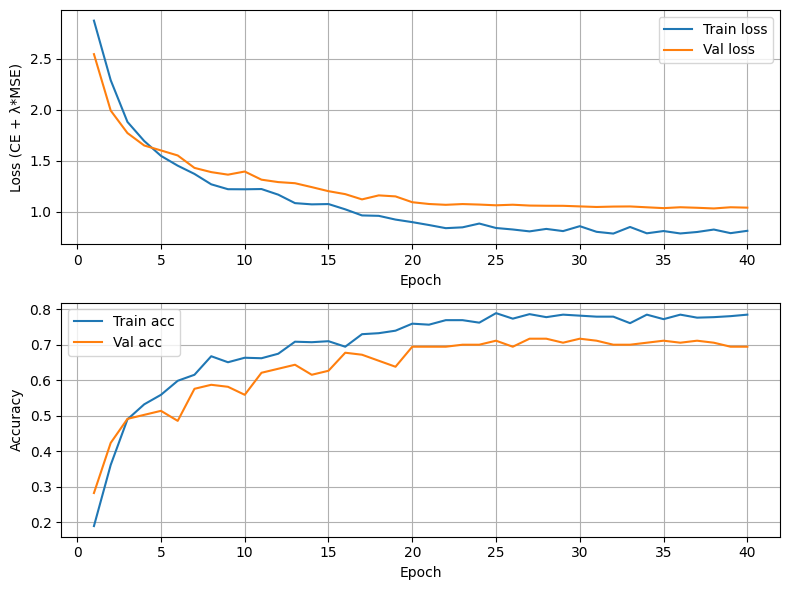


Epoch-wise metrics:
    epoch  train_loss  val_loss  train_acc   val_acc
0       1    2.871685  2.543671   0.189266  0.282486
1       2    2.288813  1.991555   0.361582  0.423729
2       3    1.880281  1.771248   0.490113  0.491525
3       4    1.693299  1.649495   0.532486  0.502825
4       5    1.548001  1.601120   0.559322  0.514124
5       6    1.451972  1.551905   0.598870  0.485876
6       7    1.371142  1.430241   0.615819  0.576271
7       8    1.269435  1.388883   0.668079  0.587571
8       9    1.221509  1.363990   0.651130  0.581921
9      10    1.220744  1.394611   0.663842  0.559322
10     11    1.223175  1.314855   0.662429  0.621469
11     12    1.168201  1.291255   0.675141  0.632768
12     13    1.085302  1.280244   0.709040  0.644068
13     14    1.073217  1.242015   0.707627  0.615819
14     15    1.076229  1.202168   0.710452  0.627119
15     16    1.024508  1.173275   0.694915  0.677966
16     17    0.964871  1.121871   0.730226  0.672316
17     18    0.960853  1.

In [ ]:
# ======================================================
# 0. 기본 설정: 드라이브 마운트 + PyTorch import
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

import os, copy, time, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ======================================================
# 1. 경로 & 하이퍼파라미터
#    - CSV: img_path + class_id + grasp(6차원) 포함
# ======================================================
LABEL_CSV    = "/content/drive/MyDrive/cornell_labels_16_with_grasp.csv"

NUM_EPOCHS   = 40
BATCH_SIZE   = 64
INIT_LR      = 1e-3
MOMENTUM     = 0.9
WEIGHT_DECAY = 2.5e-4     # Shared CNN 논문 값(0.00025)
GRASP_DIM    = 6          # (cx, cy, h, w, sin2θ, cos2θ)
LAMBDA_REG   = 1.0        # 회귀 손실 가중치

# ======================================================
# 2. 데이터셋 & DataLoader
#    - ImageNet mean/std 로 normalize (pretrained와 일치)
#    - CSV -> train/val 랜덤 8:2 split
#    - class_id를 0~(C-1)로 reindex
# ======================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

df_all = pd.read_csv(LABEL_CSV)
print("총 라벨 행 개수:", len(df_all))
print(df_all.head())

# 원래 class_id 값 분포 확인
orig_ids = sorted(df_all["class_id"].unique())
print("원래 class_id들:", orig_ids, "(개수:", len(orig_ids), ")")

# class_id -> 0..C-1 로 재매핑
id_to_idx = {cid: i for i, cid in enumerate(orig_ids)}
df_all["class_idx"] = df_all["class_id"].map(id_to_idx).astype(int)

num_classes = len(orig_ids)
print("num_classes (reindexed):", num_classes)
print(df_all[["class_id", "class_idx"]].head())

# 간단히 전체를 섞은 후 8:2로 train/val 분할
df_all = df_all.sample(frac=1.0, random_state=42).reset_index(drop=True)
n_train = int(len(df_all) * 0.8)

df_train = df_all.iloc[:n_train].copy()
df_val   = df_all.iloc[n_train:].copy()

print("train 개수:", len(df_train))
print("val 개수:", len(df_val))

class CornellMultiTaskDataset(Dataset):
    """
    CSV 한 줄 -> (이미지, class_idx, grasp_vector(6))
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["img_path"]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        cls = int(row["class_idx"])  # ★ reindexed label 사용
        grasp = torch.tensor([
            row["cx"],
            row["cy"],
            row["h"],
            row["w"],
            row["sin2theta"],
            row["cos2theta"],
        ], dtype=torch.float32)

        return img, cls, grasp

train_dataset = CornellMultiTaskDataset(df_train, transform=train_transform)
val_dataset   = CornellMultiTaskDataset(df_val,   transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

dataloaders = {"train": train_loader, "val": val_loader}

# ======================================================
# 3. SharedAlexNet: AlexNet 기반 Shared CNN + 두 개 head
#    - features + shared_fc 는 공유
#    - cls_head: class logits
#    - reg_head: grasp 회귀(6차원)
# ======================================================
class SharedAlexNet(nn.Module):
    def __init__(self, base_model, num_classes, grasp_dim=6):
        super().__init__()
        self.features = base_model.features
        self.avgpool  = base_model.avgpool

        # base_model.classifier:
        # [0] Dropout
        # [1] Linear(256*6*6 -> 4096)
        # [2] ReLU
        # [3] Dropout
        # [4] Linear(4096 -> 4096)
        # [5] ReLU
        # [6] Linear(4096 -> 1000)
        # 마지막 FC(1000클래스)는 버리고, 앞의 6개만 shared_fc로 사용
        self.shared_fc = nn.Sequential(*list(base_model.classifier[:-1]))
        in_features = base_model.classifier[-1].in_features  # 4096

        self.cls_head = nn.Linear(in_features, num_classes)
        self.reg_head = nn.Linear(in_features, grasp_dim)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        z = self.shared_fc(x)
        logits = self.cls_head(z)   # 분류용
        grasps = self.reg_head(z)   # 회귀용 (cx, cy, h, w, sin2θ, cos2θ)
        return logits, grasps

# pretrained AlexNet 불러오기
try:
    weights = models.AlexNet_Weights.IMAGENET1K_V1
    base_alex = models.alexnet(weights=weights)
except AttributeError:
    base_alex = models.alexnet(pretrained=True)

model = SharedAlexNet(base_alex, num_classes=num_classes, grasp_dim=GRASP_DIM)

# Conv feature extractor는 고정
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)
print(model)

# ======================================================
# 4. loss, optimizer, scheduler 설정
#    - CE(class) + λ * MSE(grasp)
# ======================================================
criterion_cls = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()

params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params_to_update,
                      lr=INIT_LR,
                      momentum=MOMENTUM,
                      weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=20,
                                      gamma=0.1)

# ======================================================
# 5. 학습 루프 (멀티태스크: 분류 + 회귀)
# ======================================================
def train_model(model, dataloaders,
                criterion_cls, criterion_reg,
                optimizer, scheduler=None,
                num_epochs=25, device="cuda",
                lambda_reg=1.0):

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        since = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        epoch_stats = {}

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels_cls, labels_grasp in dataloaders[phase]:
                inputs       = inputs.to(device)
                labels_cls   = labels_cls.to(device)
                labels_grasp = labels_grasp.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    logits, grasps_pred = model(inputs)

                    loss_cls = criterion_cls(logits, labels_cls)
                    loss_reg = criterion_reg(grasps_pred, labels_grasp)
                    loss = loss_cls + lambda_reg * loss_reg

                    _, preds = torch.max(logits, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels_cls).item()
                total_samples    += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc  = running_corrects / total_samples

            epoch_stats[phase] = (epoch_loss, epoch_acc)
            print(f"{phase:5s} | loss: {epoch_loss:.4f}  acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler is not None:
            scheduler.step()

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_stats["train"][0])
        history["train_acc"].append(epoch_stats["train"][1])
        history["val_loss"].append(epoch_stats["val"][0])
        history["val_acc"].append(epoch_stats["val"][1])

        time_elapsed = time.time() - since
        print(f"Epoch time: {time_elapsed:.1f} sec")

    print(f"\nBest val_acc: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    df_hist = pd.DataFrame(history)
    return model, df_hist

# 실제 학습 실행
model_ft, df_hist = train_model(
    model,
    dataloaders,
    criterion_cls,
    criterion_reg,
    optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    lambda_reg=LAMBDA_REG,
)

# ======================================================
# 6. 결과 그래프 & 테이블 출력
# ======================================================
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(df_hist["epoch"], df_hist["train_loss"], label="Train loss")
plt.plot(df_hist["epoch"], df_hist["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (CE + λ*MSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_hist["epoch"], df_hist["train_acc"], label="Train acc")
plt.plot(df_hist["epoch"], df_hist["val_acc"],   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nEpoch-wise metrics:")
print(df_hist)


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/shared_alexnet_grasp.pth"

# class id 매핑
checkpoint = {
    "model_state_dict": model_ft.state_dict(),
    "id_to_idx": id_to_idx,                  # {원래 class_id: 0~C-1}
    "orig_ids": orig_ids,                    # 원래 class_id 리스트
    "imagenet_mean": imagenet_mean,
    "imagenet_std": imagenet_std,
}

torch.save(checkpoint, SAVE_PATH)
print("saved to:", SAVE_PATH)


saved to: /content/drive/MyDrive/shared_alexnet_grasp.pth
